<a href="https://www.kaggle.com/code/tauilabdelilah/implementation-cyclegan?scriptVersionId=99579692" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**In this notebook we will implement CycleGan from scratch.**

In the first part I am gonna do a quick overview for the paper, to answer the questions bellow:
* What CycleGan is?
* How the trainig looks like?
* How the architecture looks like?

But the main part of this notebook is gonna be for the implementation using tensorflow and keras.

# Table of Contents:

* [Overview for the paper](#c1)
* [Load all dependencies we need](#c2)
* [Set up TPU](#c3)
* [Hyperparameter](#c4)
* [Data Processing](#c5)
* [Define models and losses](#c6)
* [Training](#c7)
* [Results](#c8)



<a id="c1"></a>

# Overview for the paper
**CycleGan** can transform inpaired images to images across domains where the dataset doesn't contains the images in one domain and their corresponding images in another domain (unsupervised learning). for example you can take an image of a horse and convert it to zebra, or take an image of summer and convert it into winter or any season you want.


In this notebbok we will convert an image into the style of Monet image

**How do we train this ?**

To train CycleGan we're gonna have two generators **G** and **F**, and we're going to have two discriminator **Dx** and **Dy**.


To make things a little bit simpler let's say that **X** is an image with no style, and **Y** is a style of Monet image.

**The generator G     :** Take an image without any style and try to convert it into style of Monet image.

**The generator F     :** Take a style of Monet image and try to convert it into an image with no style.

**The discriminator Dy:** Try to say if an image of style of Monet image is 'Real' or 'Fake' 

**The discriminator Dx:** Try to say if an normal image with no style is 'Real' or 'Fake' 

This is sort of a standard GAN setup except we have double the ammount of discriminators and genertos, normally we have one generator and one discriminator.


The authors add an additional loss term, they called a cycle consistency. If we take an image X, and try to generate Y^ the style of Monet for X using the generator G, and then if we take Y^ and try to generate X^ an image with no Monet style using the generator F. We should ideally have X=X^, and we enforced this with an L1-loss.



They also add a sort of idetity mapping loss. If we take an image X with no Monet style, and send it to the generator F that is supposed to generate images with no Monet style, then it shouldn't do anything and output the same image X, and again we enforced this with an L1-loss. The reason why the authors add this loss is because they don't want the generators to change the coloring or the tint of the image too much.

For the final loss for each generator we have a standard GAN loss(The adversial loss), but instead of BinaryCrossentropy they used least squares loss, then we have cycle consistency loss, and finally we have the idetity loss. 

> the idetity loss is not acctualy used in all dataset.

For the discriminator loss it pretty standard, it will be identify if an image 'Real' or 'Fake'. 

**How the architecture looks like?**

The generator has three sections: 
* Encoder that take as input the image and hase three convolution layers all with a stride of two.
* Transformer wich is a series of six residual blocks
* Decoder which uses two transpose convolutions to enlarge the representation size, and one output layer to produce the final image in RGB



The discriminator it can be pretty simple, it has four convolution layers all with a stride of two, and the output is a patchGAN, because we're not going to output a single scaler between 0 and 1, but what we are going to output is a grid of values, each of those values are going to be between 0 and 1. It called patchGan because each of those values corresponds to seeing a patch in the original image.




Now let's focus to build cycleGAN from scratch to convert an image into the style of Monet image.

<a id="c2"></a>
# Load all dependencies we need


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from PIL import Image
from kaggle_datasets import KaggleDatasets

2022-06-29 05:23:19.126987: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-29 05:23:19.127136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<a id="c3"></a>
# Set up TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-06-29 05:23:24.835055: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-29 05:23:24.837765: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-29 05:23:24.837799: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 05:23:24.837827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d7d7aa3c9c46): /proc/driver/nvidia/version does not exist
2022-06-29 05:23:24.840811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


<a id="c4"></a>
# Hyperparameter 

In [3]:
datafolder = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(datafolder + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(datafolder + '/photo_tfrec/*.tfrec'))
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1
OUTPUT_CHANNELS = 3


2022-06-29 05:23:31.778062: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-29 05:23:31.867717: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


<a id="c5"></a>
# Data Processing 

Let's first see how the images looks like.

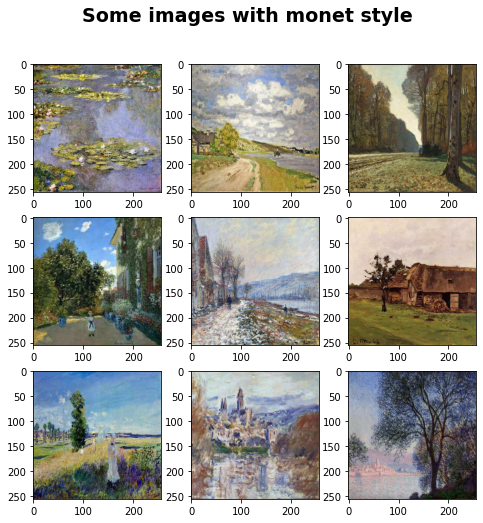

In [4]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some images with monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(Image.open('../input/gan-getting-started/monet_jpg/'+os.listdir('../input/gan-getting-started/monet_jpg')[ind]))
        ind += 1

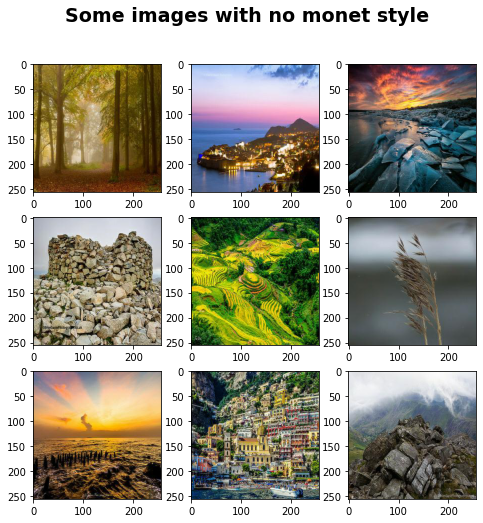

In [5]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some images with no monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(Image.open('../input/gan-getting-started/photo_jpg/'+os.listdir('../input/gan-getting-started/photo_jpg')[ind]))
        ind += 1

**Data aumgmentation:** it a technique to increase the diversity of the training set by applying random (but realistic) transformations, such as image rotation, and it can be done very easily using the API **tf.image**. To learn more about it check out the official decantation: https://www.tensorflow.org/tutorials/images/data_augmentation.

In [6]:
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image

Now let's check how the images look like after applying data augmentation

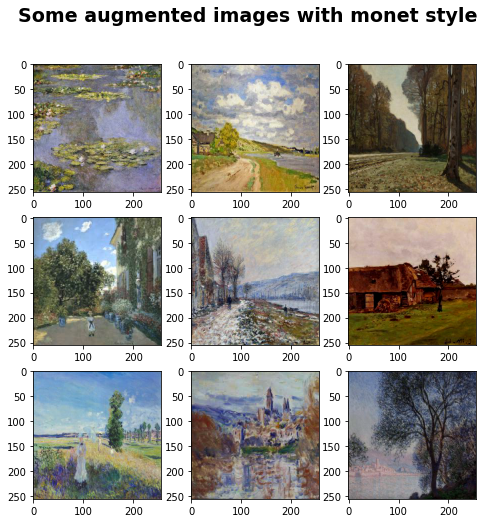

In [7]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some augmented images with monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(data_augment(np.array(Image.open('../input/gan-getting-started/monet_jpg/'+os.listdir('../input/gan-getting-started/monet_jpg')[ind]))))
        ind += 1

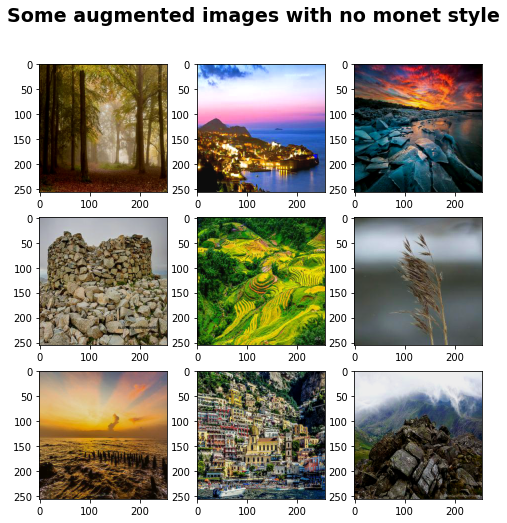

In [8]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some augmented images with no monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(data_augment(np.array(Image.open('../input/gan-getting-started/photo_jpg/'+os.listdir('../input/gan-getting-started/photo_jpg')[ind]))))
        ind += 1

You can notice that some images don't change, that because the augmentation function augments the dataset randomly. You can play with the function data_augment to make different augmented data, but try to keep it realistic.

**Transform dataset into TFRecord format:** is a simple format for storing a sequence of binary records to make processing dataset more easily and efficiently, especialy when the dataset is large and complex.

In this dataset, the images already stored in TFRecord. But you can create a tfrecord-format for any dataset you want, for more information check out the official decantation: https://www.tensorflow.org/tutorials/load_data/tfrecord.

Now let's define a function **decode_image** that decode a JPEG-encoded image to a uint8 tensor, casts it to a float32, divide it by 127.5 and subtract it by 1, to make the values in the tensor between -1 and 1, and finally, reshape it to (IMAGE_SIZE,IMAGE_SIZE, NUM_CHANNEL) .

In [9]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

Now let's define a function **read_tfrecord** to Parses a single Example proto.

In [10]:
def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Now let's define a function **load_dataset** to load our dataset.

In [11]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [12]:
monet_ds = load_dataset(MONET_FILENAMES).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)

Now let's define a function **get_gan_dataset** that load datasets from monet_fils, and photo_files, then augment the data with the function that we defined earlier  **data_augment**, then let's combine consecutive elements of this dataset into batches, then let's use prefetch, to allows later elements to be prepared while the current element is being processed. To improve latency and throughput, at the cost of using additional memory to store prefetched elements. and let's create our final Dataset by zipping together the given datasets (monet_ds and photo_ds).

Check out the official documentation to learn more about how to work with tf.data.Dataset :https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch

In [13]:
def get_gan_dataset(monet_files, photo_files, batch_size=BATCH_SIZE):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    monet_ds = monet_ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    photo_ds = photo_ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        
    monet_ds = monet_ds.batch(batch_size)
    photo_ds = photo_ds.batch(batch_size)
    
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

final_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE)

<a id="c6"></a>

# Define models and losses

To create our neural netwoeks easily, we will use powerful API tensorflow.keras.

Check out the officiel documentation foe more information: https://www.tensorflow.org/tutorials/customization/custom_layers

Let's start by the the generator.

To make a clear code let's define a layer for down_sample, and onother layer for up_sample.

In [14]:
def down_sample(filters, size, apply_instancenorm=True):
    # In the paper the weights are initialized from a Gaussian distribution N (0, 0.02).
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

In [15]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),
        down_sample(128, 4),                        
        down_sample(256, 4),                        
        down_sample(512, 4),                        
        down_sample(512, 4),                      
        down_sample(512, 4),                      
        down_sample(512, 4),                      
        down_sample(512, 4),                      
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),    
        up_sample(512, 4, apply_dropout=True),    
        up_sample(512, 4, apply_dropout=True),    
        up_sample(512, 4),                          
        up_sample(256, 4),                         
        up_sample(128, 4),                           
        up_sample(64, 4),                           
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # The last activaltion function is tanh because we want to force the model to generate pixels between 1 and -1, to be the same as the input pixels after preprocessing.
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 
   

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Now let's build the discriminator

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    down1 = down_sample(64, 4, False)(x)       
    down2 = down_sample(128, 4)(down1)        
    down3 = down_sample(256, 4)(down2)        

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

Now let's create the models in strategy.scope() for TPU

In [18]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet style 
    photo_generator = Generator() # transforms Monet style to be more like photos

    monet_discriminator = Discriminator() # differentiates real images with Monet style andi mages with generated Monet style
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Now let's build CycleGan class

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator, 
        lambda_cycle=10, 
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent=True) as tape:
        
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now let's build the loss function for the discriminator that compares the original images to the grid of 1, and the false ones to the grid of 0. The ideal discriminant will output only the grid of 1 for the true image and the grid of zeros for false.

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

Now let's build the loss function for the generator that  tries to trick the discriminator into generating an image so that the discriminator considers it original. An ideal generator will cause the discriminator on the output to return a grid filled with 1.

In [21]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

Now let's build the Cycle consistency, wich is the arithmetic mean of the differences between the original photo and the transformed twice.

In [22]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

Now let's build the Identity loss, that is used to compare the image x and that image generator F that produces the images. We expect F (x) ~ x, i.e. if the Monet style image generator is a Monet image, the output should get the same image.

In [23]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

<a id="c7"></a>
# Training

Let's initialize the optimizers for the models in strategy.scope() because we are using TPU

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Now let's compile and fit  the model

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [26]:
cycle_gan_model.fit(
    final_dataset, 
    epochs=100
)

Epoch 1/100
300/300 [==============================] - 142s 125ms/step - monet_gen_loss: 4.3543 - photo_gen_loss: 4.4254 - monet_disc_loss: 0.6778 - photo_disc_loss: 0.6757
Epoch 2/100


2022-06-29 05:26:18.908287: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 13511, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1656480378.904642816","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 13511, Output num: 2","grpc_status":3}


300/300 [==============================] - 37s 125ms/step - monet_gen_loss: 3.3454 - photo_gen_loss: 3.3993 - monet_disc_loss: 0.6590 - photo_disc_loss: 0.6472
Epoch 3/100
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 3.0613 - photo_gen_loss: 3.1280 - monet_disc_loss: 0.6455 - photo_disc_loss: 0.6387
Epoch 4/100
300/300 [==============================] - 37s 125ms/step - monet_gen_loss: 2.9941 - photo_gen_loss: 3.0298 - monet_disc_loss: 0.6321 - photo_disc_loss: 0.6365
Epoch 5/100
300/300 [==============================] - 37s 125ms/step - monet_gen_loss: 2.9461 - photo_gen_loss: 2.9324 - monet_disc_loss: 0.6179 - photo_disc_loss: 0.6347
Epoch 6/100
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 3.0108 - photo_gen_loss: 3.0151 - monet_disc_loss: 0.6092 - photo_disc_loss: 0.6223
Epoch 7/100
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 2.9475 - photo_gen_loss: 2.9355 - monet_disc_loss: 0.6132 - phot

<a id="c8"></a>
# Results

2022-06-29 06:29:37.425843: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 296914, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1656484177.425760282","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 296914, Output num: 0","grpc_status":3}


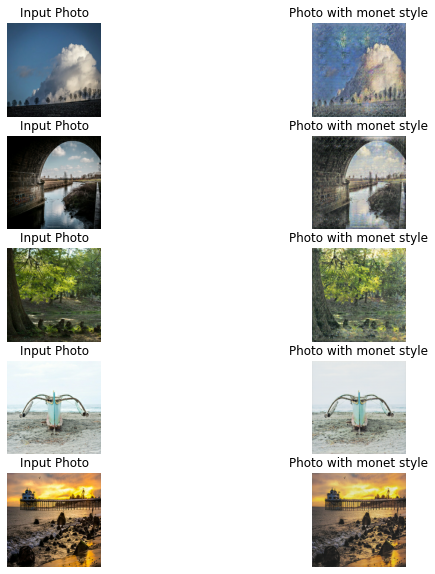

In [27]:
_, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Photo with monet style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [28]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

2022-06-29 07:02:56.623474: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4871623, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1656486176.623378117","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4871623, Output num: 0","grpc_status":3}


'/kaggle/working/images.zip'